# GTEx RNA-seq data processing for eQTLs : Genotype

## The source files of the code used in this notebook are in:

### <code>https://github.com/bee-hive/RNAseq_pipeline/tree/master/Scripts/genotype/gtex</code>

This notebook outlines how genotype data is obtained and processed in the eQTL studies. The specific dataset used in this notebook comes from the GTEx dataset, but the same principle applies to other datasets as well.

# Summary

To summarize the pipeline portion of this document, we have the following:

In the directory:

<code>/tigress/BEE/eQTLs/Data/Genotype/GTEx/</code>

### The original raw vcf files from GTEx (with and without imputation)
### Genotype PCs, also from GTEx (top 20)
### Genotypes with imputation, in alleleic dosage and vcf formats
### - 6226121 Markers (6222721 with annotated position) over 450 individuals (449 represented in gene expression values we are testing)
### Phased genotypes with imputation
### List of samples and subjects with genotypes
### Various subsetting of the cis-variants that we are going to use in our pipeline

# Begin notebook

## Data source

The data source in this case is the GTEx phase 1 release, with the raw data shared in:

<code>/tigress/BEE/gtex/dbGaP-7716/45696/gtex/exchange/GTEx_phs000424/exchange/analysis_releases/GTEx_Analysis_2015-01-12/genotypes</code>

I've replicated the [README](https://github.com/bee-hive/bjo-notebook/tree/master/Data/RNAseq/genotype/gtex/README) files from the dbGaP for convenience, and there are a few points worth noting:

#### All files use hg19 (GRCh 37) version of the genome
#### There are two types of IDs used
- dbSNP ID format: rs########
- GTEx custom ID format: Chr_Pos_REF_ALT_b37, for variants lacking a formal dbSNP ID

#### The genotypes come from two sources
- Illumina's OMNI arrays: Raw intensity files for the OMNI 2.5M arrays
- Imputed VCF for 450 GTEx donors.

In other words, there are genotype intensities taken from the original Illumina OMNI arrays, as well as genotypes that have been imputed further. We will see that unimputed genotype files have a lot of missing data.

### Some more information on genotype prep and imputation

The readme files in pdf format provide a lot of relevant information, and there are some details worth noting:

- The original genotype is actually a combination of OMNI 2.5M array (272 GTEx samples) results from the Broad institute and OMNI 5M array (183 GTEx samples) results taken independently. Out of the total of 455 individuals, there were 296 males and 159 females.
- The final count is 450; 3 were removed due to cryptic family relationships, 1 due to Klinefelters (XXY), and 1 due to chr17 trisomy.
- The experiments were merged and filtered for minor allele frequency (MAF) of 1%, and further QC'd. The final SNP count after the processing is 1,883,274.


In [1]:
%%bash
# This part will depend on where the code is being run - the following code uses relative addresses
export proj='/Users/brian_jo/Desktop/Project/RNAseq_pipeline'

In [3]:
from IPython.display import Image
import os
proj = os.environ['proj']

/Users/brian_jo/Desktop/Project/RNAseq_pipeline


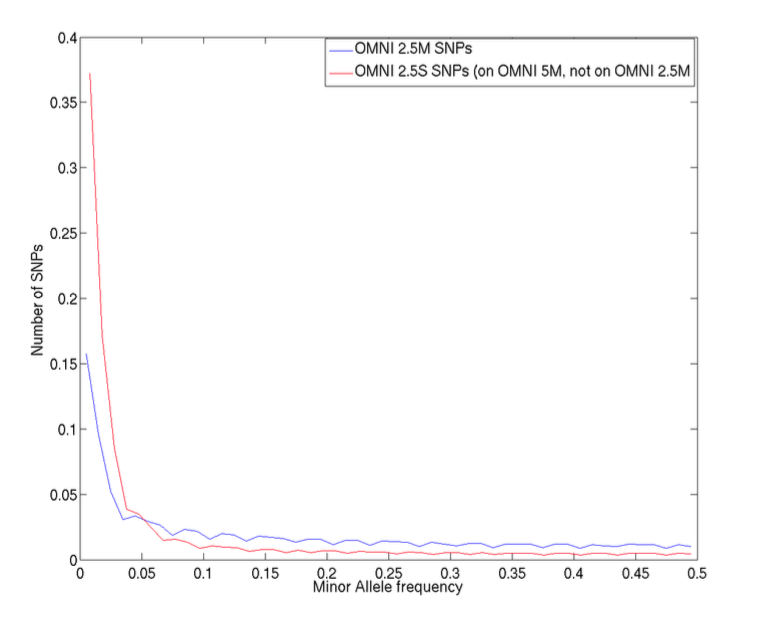

In [4]:
Image(filename=proj+'/Analysis/auxiliary/genotype/MAF_SNPset.png', width = 500) 

The plot shows distribution of MAF for the 2.5M array and the 5M array (red line is the set of SNPs on 5M but not on 2.5M array). There are many more low MAF SNPs that are present in the 5M array but not in the 2.5M array.

- The imputation was performed using IMPUTE2 and using the 1000 Genomes Project data as the reference panel, in 3MB segments, and later merged.

IMPUTE2: https://mathgen.stats.ox.ac.uk/impute/impute_v2.html

Imputation protocol: https://sites.google.com/a/broadinstitute.org/ricopili/imputation

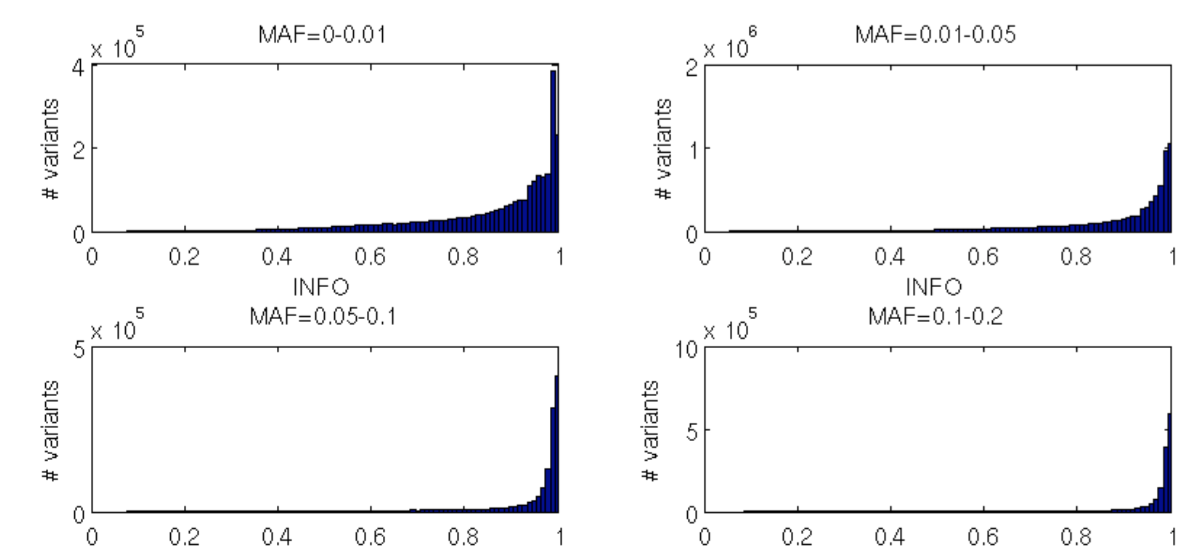

In [5]:
Image(filename=proj+'/Analysis/auxiliary/genotype/INFO_vs_MAF.png', width = 600) 

The histogram of INFO (Genotype imputation score), stratified by MAF. We can see that the scores look much better after MAF 0.05. I truncated the plot at 0.2 as the plots for higher MAF look basically identical to the last row.

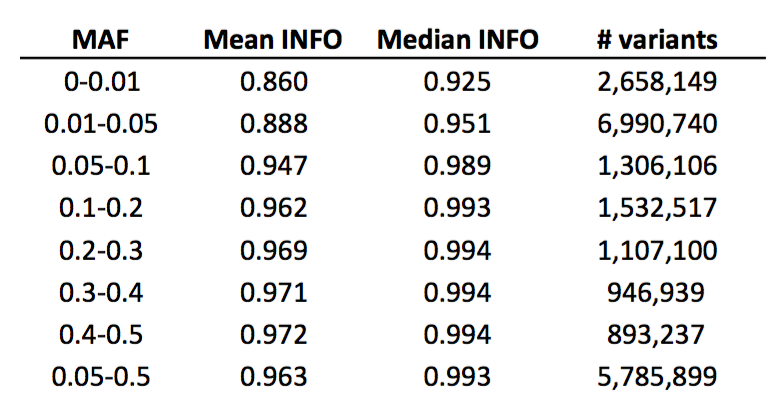

In [6]:
Image(filename=proj+'/Analysis/auxiliary/genotype/INFOtable.png', width = 500) 

If we threshold at MAF 0.05, we can expect about 6M SNPs. If we threshold at MAF 0.01, we can expect more than 12M SNPs.

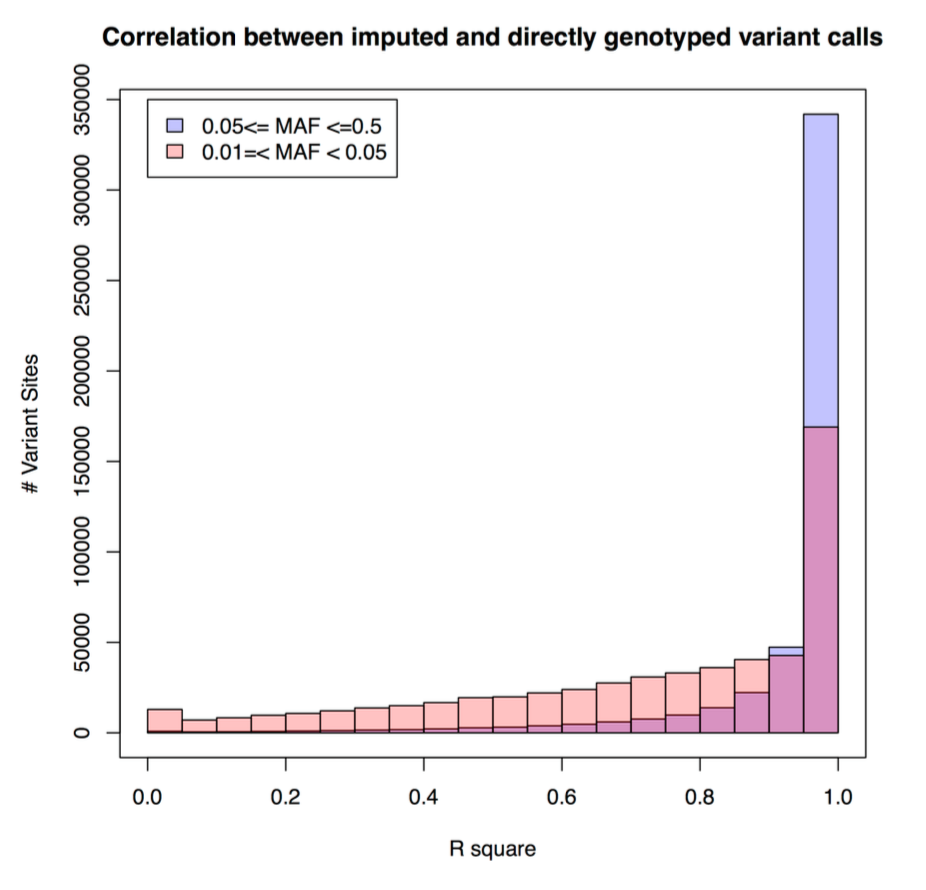

In [7]:
Image(filename=proj+'/Analysis/auxiliary/genotype/Imputed_hardcall_comp.png', width = 500)

Correlation between imputation calls and hard calls, to test the accuracy of imputation. The R square is calculated on on SNPs on 5M but not on 2.5M, using the SNPs from 2.5M as reference. I have a feeling that this plot is a bit off, but I think the take-home point is that we can be reasonably confident for MAF above 0.05.

### Genotype PCs

The Genotype PCs were calculated on the 451 individuals (with the chr17 trisomy individual), and genome-wide set of linkage disequilibrium (LD)-pruned (at R squared of 0.2) variants generated from best-guess genotype calls after imputation.

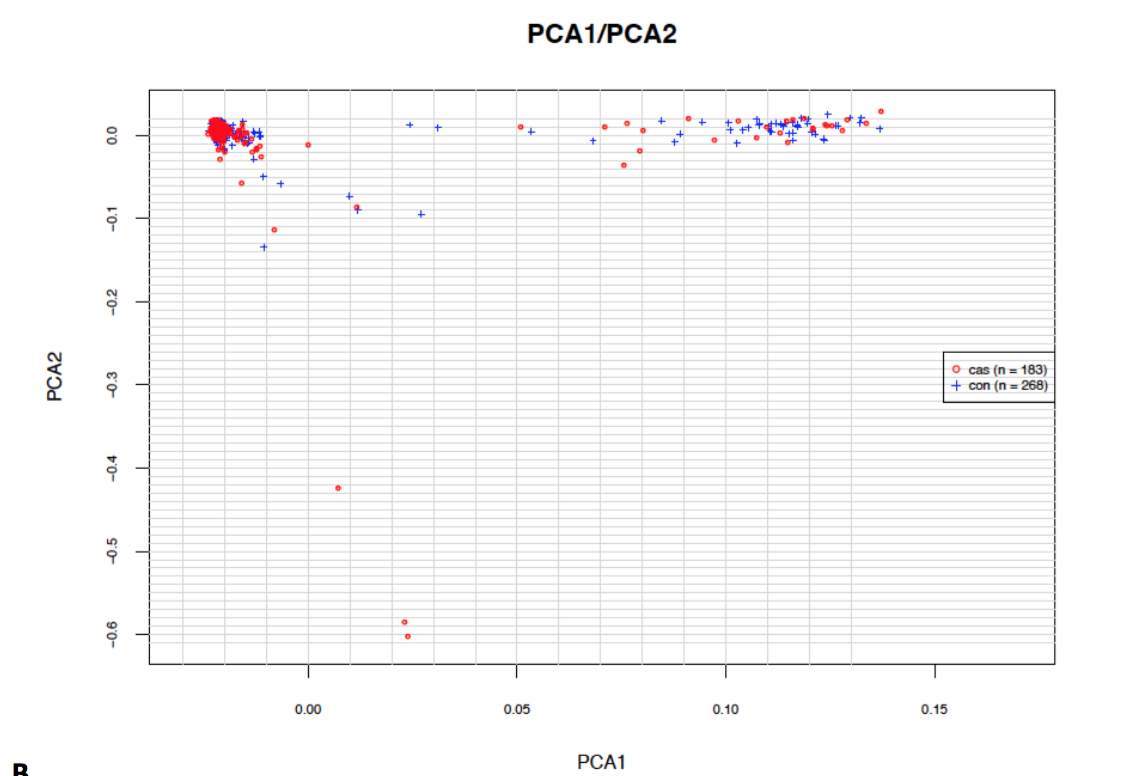

In [8]:
Image(filename=proj+'/Analysis/auxiliary/genotype/GenotypePCs.png', width = 700)

The top left corresponds to people of European descent, and top right to people of African descent. Although the documentation said the outliers were not identified, our independent analysis identified the bottom two individuals as Asian and the one individual in the (veritical) middle as Native American. The different colors correspond to different platforms (2.5M vs 5M)

Another interesting point of note: The 9th genotype PC was associated significantly with the platform. (r=-0.18, p=0.00053)

### Phasing of variants

Information on phased genotype is important in many analyses, including allele-specific expression (ASE) and population genetics studies that use haplotype information. The GTEx consortium also shared their method of producing phased genotype data. Specifically, the phasing was also performed with IMPUTE2 and using the unphased, imputed genotypes, and 1000 Genomes data as reference.

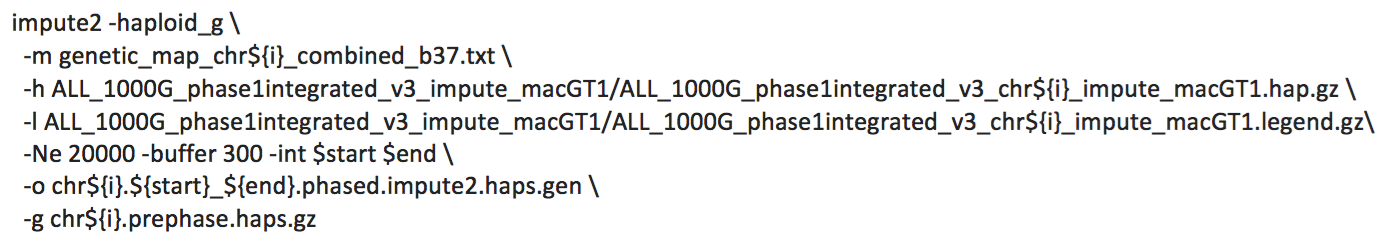

In [9]:
Image(filename=proj+'/Analysis/auxiliary/genotype/phasing_command.png')

Example phasing command used for IMPUTE2. The output of this command is still diploid imputation probabilities, even though it performs haploid imputation.

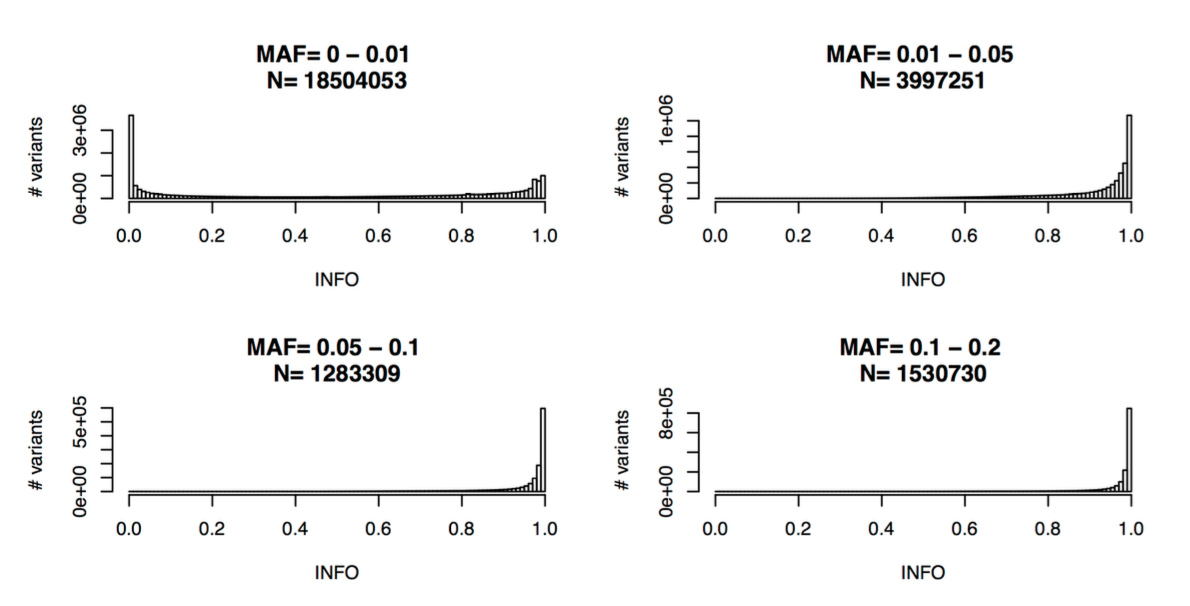

In [10]:
Image(filename=proj+'/Analysis/auxiliary/genotype/INFO_vs_MAF_phase.png', width = 700)

The histogram of INFO (Genotype imputation score), stratified by MAF, similar to above. We can see that phasing is especially tough for MAF below 0.01, but after that it performs reasonably well. I truncated the plot at 0.2 as the plots for higher MAF look basically identical to the last row.

#### The final phased array VCF contains 11,607,846 variants across 450 GTEx donors

Although there is more information on the imputation and phasing of the X chromosome, let's move on for now with autosomal chromosomes (I'll return to the X-chromsome genotypes when I get a chance)

## Peeking into the actual data, and re-formatting

Now that we know a lot more about how the data was derived, and relatively confident about the quality of the data, let's actually take a sneak peek at the raw data, and process is to fit our needs.

In the genotype data directory,

<code>/tigress/BEE/eQTLs/Data/Genotype/GTEx</code>

there are the vcf files for original and imputed genotypes:

<code>GTEx_Analysis_2015-01-12_OMNI_2.5M_275Indiv_allchr_original_genot.vcf.gz</code>

And 

<code>GTEx_Analysis_2015-01-12_OMNI_2.5M_5M_450Indiv_allchr_genot_imput_info04_maf01_HWEp1E6_ConstrVarIDs.vcf.gz</code>

Taking a look at an example line from the imputed vcf file:

<code>
1       52238   1_52238_T_G_b37 T       G       .       PASS    EXP_FREQ_A1=0.920;IMPINFO=0.481;CERTAINTY=0.906;TYPE=0;MISS=0.2800;HW=1 GT:GL:DS        ./.:0,0.238,0.762:1.762 ./.:0.051,0.35,0.599:1.548      0/1:0.005,0.963,0.032:1.02
7     1/1:0,0.059,0.941:1.941 1/1:0,0.031,0.969:1.969 ./.:0.432,0.552,0.016:0.584     1/1:0,0.01,0.990:1.99   1/1:0,0.038,0.962:1.962 1/1:0,0.015,0.985:1.98
</code>

We can see the chromosome position, the reference and alternate genotype, allele frequence (0.920 or MAF 8%), confidence of imputation (IMPINFO of 0.481), whether the SNP was imputed or genotyped (TYPE of 0 means imputed, 2 means genotyped), Hardy-Weinberg P-value (HW=1), and the GT:GL:DS value for each individual.

- GT is Best Guessed Genotype with posterior probability threshold of 0.9
- GL is Posterior probability of 0/0, 0/1, and 1/1
- DS is Dosage, or E(GL)

Therefore, if we were to use threshold 0.9, we would only take genotypes that are not ./. (GT, discrete)
If we were to use the dosage, or the expected value of the minor allele, we would use the DS, which is continuous from 0 to 2

### Before we go further - some useful files

Let's obtain some useful files for this part of the processing. These have been either obtained or produced through previous pipelines so that we don't have to reinvent the wheel.

- List of subjects with genotypes:

<code>$proj/Data/Resources/gtex/genotype/subjects_with_genotypes.txt</code>

- List of samples with genotypes:

<code>$proj/Data/Resources/gtex/genotype/samples_with_genotypes.txt</code>

The difference between the two is explained in the covariates_and_additional_info notebook.

- The genotype PCs from imputed genotypes:

<code>$proj/Data/Resources/gtex/genotype/GTEx_Genotype_PCs_top20.txt </code>

### Split up the chromosome vcf files by chromosome, and filter by maf

For speed in downstream analyses, it would be beneficial to split up the vcf files by chromosome, and also filter by maf. We will produce two versions: maf 0.01 and maf 0.05 (We will mostly use maf 0.05 for downstream analyses)

In [ ]:
%%bash
/usr/bin/python2.7 /tigress/BEE/RNAseq/Scripts/genotype/gtex/vcf_split_and_filter_wrapper.py maf01
/usr/bin/python2.7 /tigress/BEE/RNAseq/Scripts/genotype/gtex/vcf_split_and_filter_wrapper.py maf05

Running the code above produces the appropriate vcf files, that are located in:

<code>/tigress/BEE/eQTLs/Data/Genotype/GTEx/imputed_genotypes/vcf</code>

The split files look like:

<code>GTEx_Analysis_2015-01-12_OMNI_2.5M_5M_450Indiv_allchr_genot_imput_info04_mafXX_HWEp1E6_ConstrVarIDs.chrXX.vcf.gz</code>

Where mafXX and chrXX specify the MAF and chromosome, respectively. There were two necessary steps of removing duplicates (probably an artifact on the GTEx side), and converting the GTEx-style IDs into dbSNP IDs (rs#######).

In [ ]:
%%bash
/usr/bin/python2.7 /tigress/BEE/RNAseq/Scripts/genotype/gtex/vcf_remove_duplicates_wrapper.py maf01
/usr/bin/python2.7 /tigress/BEE/RNAseq/Scripts/genotype/gtex/vcf_remove_duplicates_wrapper.py maf05

# Note: these scripts were borrowed from a previous pipeline, and thus needs minor alterations

In [4]:
%%bash 
cd /tigress/BEE/eQTLs/Data/Genotype/GTEx/imputed_genotypes/vcf
cat *_dup_report* | sort -u > tmp
grep -f tmp /tigress/BEE/gtex/data/genotype/auxiliary/GTEx_Analysis_2015-01-12_OMNI_2.5M_5M_450Indiv_allchr_genot_imput_info04_maf01_HWEp1E6_VarID_Lookup_Table.txt
rm tmp

2	72000000	2_72000000_G_A_b37	G	A	rs61573637	rs61573637	1
2	72000000	2_72000000_G_A_b37	G	A	rs61573637	rs61573637	1
10	12000000	10_12000000_A_T_b37	A	T	rs74733400	rs74733400	1
10	12000000	10_12000000_A_T_b37	A	T	rs74733400	rs74733400	1
12	48000000	12_48000000_T_C_b37	T	C	rs855274	rs855274	1
12	48000000	12_48000000_T_C_b37	T	C	rs855274	rs855274	1


Three duplicates, at SNP locations divisible by 1 million. (GTEx probably had a small bug in this processing step)

In [ ]:
%%bash
/usr/bin/python2.7 /tigress/BEE/RNAseq/Scripts/genotype/gtex/vcf_translate_names_wrapper.py maf01
/usr/bin/python2.7 /tigress/BEE/RNAseq/Scripts/genotype/gtex/vcf_translate_names_wrapper.py maf05

# Note: these scripts were borrowed from a previous pipeline, and thus needs minor alterations

After this step, we can find files that look like:

<code>GTEx_Analysis_2015-01-12_OMNI_2.5M_5M_450Indiv_allchr_genot_imput_info04_mafXX_HWEp1E6_dbSNPIDs.chrXX.vcf.gz</code>

An example line from chr9 file looks like this:

<code>
9       10177   rs185444096     C       T       .       PASS    EXP_FREQ_A1=0.
069;IMPINFO=0.427;CERTAINTY=0.908;TYPE=0;MISS=0.3067;HW=1 GT:GL:DS        ./.:
0.884,0.116,0:0.116 0/0:0.913,0.087,0:0.087 0/0:0.925,0.075,0:0.075 0/0:0.928,
0.072,0:0.072 0/0:0.998,0.002,0:0.002 ./.:0.897,0.103,0:0.103 ./.:0.587,0.372,
0.041:0.454     ./.:0.704,0.276,0.02:0.316
</code>

### Conversion of the genotype matrix into alleleic dosage format, both discrete and continuous

Since most eQTL detection packages take genotypes not in vcf format but in matrix format, and since it will be much better to import into R, we will convert the vcf files into alleleic dosage format, located at:

/tigress/BEE/eQTLs/Data/Genotype/GTEx/imputed_genotypes/allelic_dosage/discrete

and 

/tigress/BEE/eQTLs/Data/Genotype/GTEx/imputed_genotypes/allelic_dosage/continuous

For illustration purposes, I'll briefly share how files were generated. First, the vcf files have been converted to the alleleic dosage format by Ian:

In [ ]:
%%bash
/usr/bin/python2.7 /tigress/BEE/RNAseq/Scripts/genotype/gtex/vcf_to_allelic_dosage_format_wrapper.py maf01
/usr/bin/python2.7 /tigress/BEE/RNAseq/Scripts/genotype/gtex/vcf_to_allelic_dosage_format_wrapper.py maf05

# Note: these script requires an installation of PLINK to run:

# http://pngu.mgh.harvard.edu/~purcell/plink/

Then, we can port in the necessary files into our Data directory:

In [ ]:
%%bash

cd /tigress/BEE/eQTLs/Data/Genotype/GTEx/imputed_genotypes/allelic_dosage/discrete
# Copy the header
for i in $(seq 1 22); \
do head -n 1 /tigress/BEE/gtex/data/genotype/imputed_genotypes/allelic_dosage/GTEx_Analysis_2015-01-12_OMNI_2.5M_5M_450Indiv_allchr_genot_imput_info04_maf05_HWEp1E6_dbSNPIDs.chr${i}.allelic_dosage.txt > GTEx_genotypes_maf05_discrete_Chr${i}.txt; \
echo $i; \
done

# Then, modify the header so that it doesn't have the "SNP" as the first enry, and convert the sample IDs to subject IDs
/usr/bin/python2.7 /tigress/BEE/eQTLs/Scripts/GTEx/Genotype/modify_header.py

# After the genotype files have been given the correct header:
for i in $(seq 1 22); \
do grep -v "^SNP" /tigress/BEE/gtex/data/genotype/imputed_genotypes/allelic_dosage/GTEx_Analysis_2015-01-12_OMNI_2.5M_5M_450Indiv_allchr_genot_imput_info04_maf05_HWEp1E6_dbSNPIDs.chr${i}.allelic_dosage.txt >> GTEx_genotypes_maf05_discrete_Chr${i}.txt; \
echo $i; \
# Remove snps that are "."
cat GTEx_genotypes_maf05_discrete_Chr${i}.txt | grep -ve '^\.' > GTEx_genotypes_maf05_discrete_Chr${i}_Final.txt; \
done

# We can repeat the same procedure for MAF 0.01, if needed.

Now we have the final discrete genotype matrices with imputed genotypes:

<code>GTEx_genotypes_maf05_discrete_ChrXX_Final.txt</code>

Doing a line count on all the files yields the following result:

#### 6226143 total, which means that there are 6226121 total genotypes (after subtracting header lines)

Let's also get the continuous genotypes:


In [6]:
%%bash

/usr/bin/python /tigress/BEE/RNAseq/Scripts/genotype/gtex/obtain_imputed_genotype_wrapper.py

sh /tigress/BEE/eQTLs/Scripts/Genotype/obtain_imputed_genotype_wrapper.sh
Number of jobs: 23


As a result, Now we also have the final continuous genotype matrices with imputed genotypes:

<code>GTEx_genotypes_maf05_continuous_ChrXX_Final.txt</code>

### Phased genotypes

For analyses that require phased genotypes, the data has also been deposited to the data directory:

/tigress/BEE/eQTLs/Data/Genotype/GTEx

The vcf file for the raw phased file is at:

GTEx_Analysis_2015-01-12_OMNI_2.5M_5M_450Indiv_chr1to22_phased_genot_imput_info04_maf01_HWEp1E6_ConstrVarIDs.vcf.gz

- You will notice that instead of just having genotypes .|., 0|0, 0|1 and 1|1, it will also have entries that are 1|0 to indicate phasing information, with the corresponding probability.

The chromosome-specific genotype files (which are probably more useful) are located at (symbolic link pointing to dataset generated by Yoson):

/tigress/BEE/eQTLs/Data/Genotype/GTEx/phased_genotypes

### Genotype permutations

In order to generate the null statistics for the eQTL mapping, we can also generate a permuted version of the genotypes, so that all the genotypic structure with in the population are destroyed and the association between genotype and expression are also destroyed. Running the following script: 

In [ ]:
%%bash

Rscript /tigress/BEE/RNAseq/Scripts/genotype/gtex/permute_genotype.R
#/usr/bin/python /tigress/BEE/eQTLs/Scripts/GTEx/Genotype/permute_genotype_by_PC.py

completes this step (Note that you need to change the genotype and destination directory in the script).

### Creating SNP metadata file for various future uses

After the pipeline has been advanced, it became more apparent that SNP-level metadata files would come in very handy. Thus, various information pertaining to each SNP that are available to us are deposited into metadata files. First, let's grab the files that are of the format:

<code>GTEx_Analysis_2015-01-12_OMNI_2.5M_5M_450Indiv_allchr_genot_imput_info04_maf01_HWEp1E6_ConstrVarIDs.chr${CHROM}.vcf.gz</code>

and convert them into tab-separated format with dbSNP ID's incorporated:

In [1]:
%%bash

/usr/bin/python /tigress/BEE/RNAseq/Scripts/genotype/gtex/vcf_create_metadata_file_wrapper.py 

Number of jobs 22
sh /tigress/BEE/eQTLs/Scripts/GTEx/Genotype/vcf_create_metadata_file.sh


In [3]:
%%bash

/usr/bin/python /tigress/BEE/RNAseq/Scripts/genotype/gtex/metadata_add_addl_info_wrapper.py

Number of jobs 22
sh /tigress/BEE/eQTLs/Scripts/GTEx/Genotype/metadata_add_addl_info.sh


### Saving SNP locations separately

Based on the SNP_metadata tables, save the positions of SNPs for quick loading in jobs.

In [ ]:
%%bash

/usr/bin/python /tigress/BEE/RNAseq/Scripts/genotype/gtex/record_snp_positions.py

10530387 SNP_positions_ChrAll.txt

We have locations recorded for 10530386 variants

### Saving SNPs that are not in a repeated element

Based on RepeatMasker annotations (that we saved in the extended metadata files above), we can write out the SNPs that are not in a repeated element separately.

Note: Previously, there was a feature that also filtered on MAF 0.05, but now this filter is applied in a tissue-specific fashion, at runtime for association testing.

In [ ]:
%%bash

Rscript /tigress/BEE/RNAseq/Scripts/genotype/gtex/collect_genotypes_not_in_repeat.R

### SNP subset collection 1: best cis-SNPs as indicated by LDACC

We are testing for enrichment of trans- signal with two promising subsetting of genetic variants. The first of such subsetting is that we take the best cis-SNPs (a SNP with the lowest p-value for each gene), and provide this list as our testing set. In order to properly show enrichment, we also contrast this result with randomly selected SNPs that have a similar tss-distance and MAF distribution as our original set. We will select this random sample 11 times and later take the median for qq-plot generation.

In [ ]:
%%bash
/usr/bin/python /tigress/BEE/RNAseq/Scripts/genotype/gtex/prepare_cis_subset_wrapper.py

### SNP subset collection 2: trait-associated SNPs from GWAS catalogue

We are testing for enrichment of trans- signal with two promising subsetting of genetic variants. The second of such subsetting is that we take the known trait-associated SNPs from the GWAS catalogue, and provide this list as our testing set. In order to properly show enrichment, we also contrast this result with randomly selected SNPs that have a similar tss-distance and MAF distribution as our original set. We will select this random sample 11 times and later take the median for qq-plot generation.

In [ ]:
%%bash
/usr/bin/python /tigress/BEE/RNAseq/Scripts/genotype/gtex/prepare_gwas_subset_wrapper.py

### Creating a concatenated SNP matrix for the cross-tissue run, with the permutations as well

In [ ]:
%%bash
/usr/bin/Rscript /tigress/BEE/RNAseq/Scripts/genotype/gtex/prepare_concatenated_exp_cov_mat.R